# CNN classifier

Congratulations, here's your first homework! You'll learn the art of training deep image classifiers. You might remember `03 seminar` about training CIFAR10 classifier, this homework is also about training **CIFAR10 classifier**, but this time you'll have to do it on your own and with some extra features.

## Data
Your dataset is CIFAR10. Check out `03 seminar` on how to load train and val data splits.

**Note:** for training you can only use `train` dataset.

## Game rules:
Maximum score you can get for this task is **10.0**.

Half of 10 points you can get by reaching high val accuracy (as listed in table below):

- accuracy > 60.0 -> **1 point**
- accuracy > 70.0 -> **2 points**
- accuracy > 80.0 -> **3 points**
- accuracy > 90.0 -> **4 points**
- accuracy > 92.5 -> **5 points**

Another half of 10 points you can get by adding following features to your training pipeline. It's okay if you see some technics for the first time (that was the idea). Feel free to google and dive into topic on your own, it's homework after all:
1. Data augmentations. Check out [this article](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced) (**1 point**)
2. [LR schedule](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ReduceLROnPlateau) (**0.5 point**)
3. Finetune pretrained model from [torchvision.models](https://pytorch.org/docs/stable/torchvision/models.html) (except AlexNet!) (**1 point**)
4. Implement [ResNet model](https://medium.com/@14prakash/understanding-and-implementing-architectures-of-resnet-and-resnext-for-state-of-the-art-image-cf51669e1624) (**2 points**)
5. Use of [tensorboardX](https://github.com/lanpa/tensorboardX) to monitor training process (**0.5 points**)

As a result you have to submit **notebook with working code** (results will be reproduced during homework cheking) and **short report** (write it in the same notebook) about things you tried and what tasks you managed to implement. Good luck and have fun!

# 1. Loading and normalizing CIFAR10
Using ``torchvision``, it’s extremely easy to load CIFAR10.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [466]:
from tqdm import tqdm_notebook as tqdm

Parameters:

In [2]:
batch_size = 4
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

CIFAR10 classes:

In [374]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_classes = len(classes)

## Добавим аугментацию изображений

За основу был взят ноутбук: https://colab.research.google.com/drive/109vu3F1LTzD1gdVV6cho9fKGx7lzbFll#scrollTo=aFtwoTIS0woY

In [7]:
# !pip install git+https://github.com/aleju/imgaug
from imgaug import augmenters as iaa
import imgaug as ia

  Cloning https://github.com/aleju/imgaug to /private/var/folders/j1/9bgzj7qn0_lb3x7wzlfbc8s80000gn/T/pip-req-build-24zguvj4
    100% |████████████████████████████████| 28.9MB 838kB/s ta 0:00:011
    100% |████████████████████████████████| 3.3MB 1.5MB/s ta 0:00:011
    100% |████████████████████████████████| 1.6MB 1.6MB/s ta 0:00:01
    100% |████████████████████████████████| 39.7MB 622kB/s ta 0:00:011  12% |████                            | 5.0MB 1.8MB/s eta 0:00:19
    100% |████████████████████████████████| 706kB 1.2MB/s ta 0:00:01    61% |███████████████████▋            | 430kB 1.4MB/s eta 0:00:01
    100% |████████████████████████████████| 4.9MB 1.6MB/s ta 0:00:011
    100% |████████████████████████████████| 1.7MB 2.0MB/s ta 0:00:01
    100% |████████████████████████████████| 51kB 7.4MB/s eta 0:00:01
  Stored in directory: /private/var/folders/j1/9bgzj7qn0_lb3x7wzlfbc8s80000gn/T/pip-ephem-wheel-cache-z5_nb9yu/wheels/9c/f6/aa/41dcf2f29cc1de1da4ad840ef5393514bead64ac9e644260ff
  Sto

In [440]:
class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
            iaa.Sometimes(0.2, iaa.GaussianBlur(sigma=(0, .75))),
            iaa.Fliplr(0.5),
            iaa.Affine(rotate=(-15, 15), mode='symmetric'),
            iaa.Sometimes(0.2, iaa.OneOf([
                iaa.Dropout(p=(0, 0.025)),
                iaa.CoarseDropout(0.02, size_percent=0.05),
            ])),
            iaa.AddToHueAndSaturation(value=(-5, 5), per_channel=True),
        ])

    def __call__(self, img):
        img = np.array(img)
        return np.ascontiguousarray(self.aug.augment_image(img))

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range ~[-1, 1]. This weird numbers are just means and stds calculated on ImageNet (check [this docs](https://pytorch.org/docs/master/torchvision/models.html) for more information).

In [441]:
transform = transforms.Compose([
    transforms.Resize(299),
    ImgAugTransform(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
#     transforms.ToPILImage(),
])

Setup dataloaders (downloading CIFAR10 can take some time):

In [442]:
%%time
train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

print("len(train_dataset) =", len(train_dataset))

val_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)
val_dataloader= torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print("len(val_dataset) =", len(val_dataset))

Files already downloaded and verified
len(train_dataset) = 50000
Files already downloaded and verified
len(val_dataset) = 10000
CPU times: user 1.44 s, sys: 353 ms, total: 1.8 s
Wall time: 1.81 s


Let us show some of the training images, for fun:

In [443]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 15, 25


def unnorm(img):
    img = np.array(img, dtype=float) / 2 + 0.5  # unnormalize
    return np.transpose(img, (1, 2, 0))

def show_dataset(dataset, n=3, m=6):
    img = np.vstack((np.hstack([unnorm(np.asarray(dataset[i][0])) for _ in range(m)]) for i in range(n)))
    plt.imshow(img)
    plt.axis('off')

/Users/maxim/code/git/fintech/learning-deep-learning/dl_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  from ipykernel import kernelapp as app
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


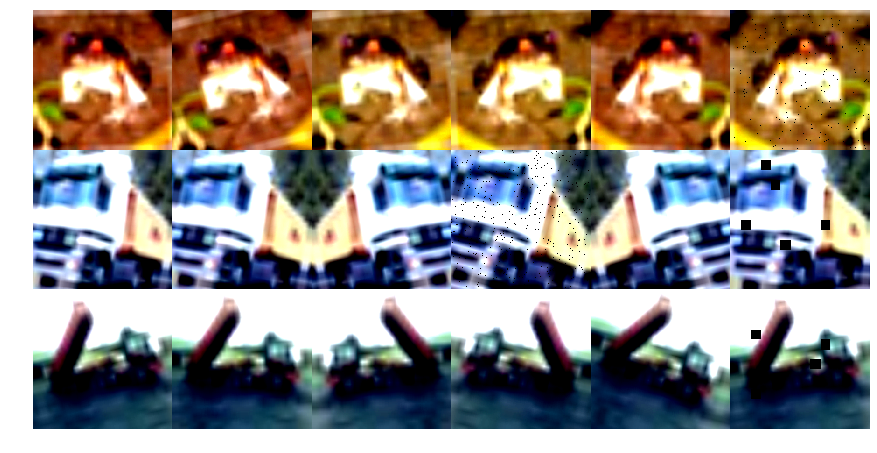

In [447]:
show_dataset(train_dataset)

# 2. Define a Convolutional Neural Network

### 1. Load and initialize the pretrained model

Now let's load already pretrained Inception_v3 model. Luckily `torchvision` gives us easy interface to load popular pretrained models (weights downloading can take some time): 

https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [454]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.0.1
Torchvision Version:  0.2.1


In [467]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [468]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [469]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [485]:
model_name = "inception"
feature_extract = True
num_epochs = 2
batch_size = 32
lr = 0.001
use_pretrained = True

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

Setup dataloaders (downloading CIFAR10 can take some time):

In [497]:
data_dir = './data'
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        ImgAugTransform(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {
    x: torchvision.datasets.CIFAR10(
        root=os.path.join(data_dir, x),
        train=(x == 'train'),
        download=True,
        transform=data_transforms[x]
    ) 
    for x in ['train', 'val']
}

# Create training and validation dataloaders
dataloaders_dict = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=1) 
    for x in ['train', 'val']
}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...
Files already downloaded and verified
Files already downloaded and verified


/Users/maxim/code/git/fintech/learning-deep-learning/dl_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  from ipykernel import kernelapp as app
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


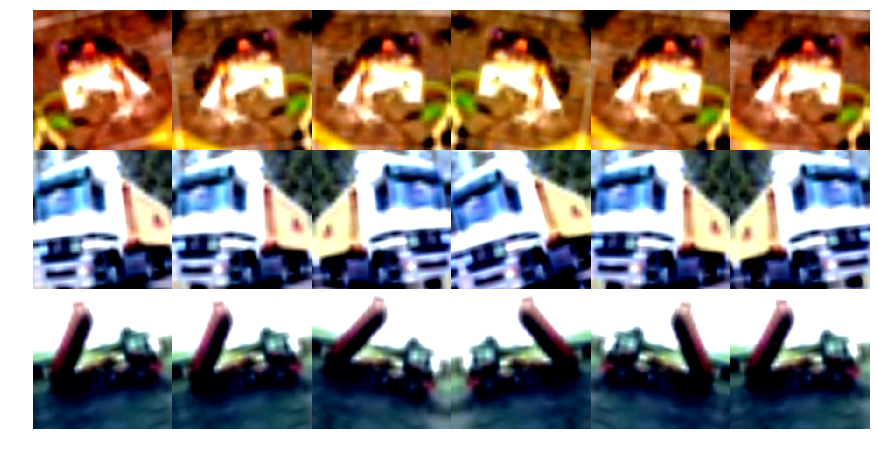

In [498]:
show_dataset(image_datasets['train'])

/Users/maxim/code/git/fintech/learning-deep-learning/dl_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  from ipykernel import kernelapp as app
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


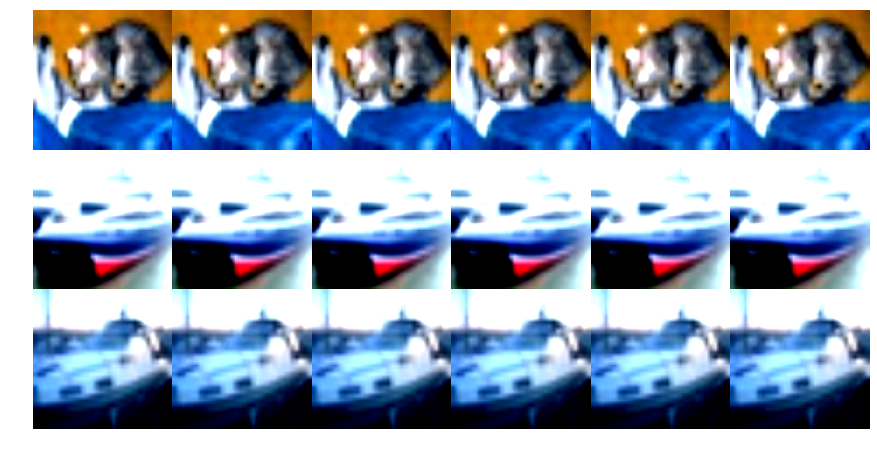

In [499]:
show_dataset(image_datasets['val'])

In [500]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
else:
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t", name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=lr)

Params to learn:
	 AuxLogits.fc.weight
	 AuxLogits.fc.bias
	 fc.weight
	 fc.bias


In [501]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(
    model_ft, dataloaders_dict, criterion, optimizer_ft, 
    num_epochs=num_epochs, is_inception=(model_name=="inception")
)

Epoch 0/1
----------


RuntimeError: DataLoader worker (pid 86860) is killed by signal: Unknown signal: 0. 

In [ ]:
model_ft = models.inception_v3(pretrained=use_pretrained)
set_parameter_requires_grad(model_ft, feature_extract)
# Handle the auxilary net
num_ftrs = model_ft.AuxLogits.fc.in_features
model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
# Handle the primary net
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs,num_classes)
input_size = 299

In [370]:
model = torchvision.models.inception_v3(pretrained=True).to(device)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /Users/maxim/.torch/models/inception_v3_google-1a9a5a14.pth
108857766it [00:23, 4613147.90it/s]


In [378]:
model.AuxLogits.fc = torch.nn.Linear(768, num_classes)
model.fc = torch.nn.Linear(2048, num_classes)

Look at [source code](https://github.com/pytorch/vision/blob/master/torchvision/models/alexnet.py) for Inception_v3 for deeper understanding of how model works. Let's print it:

In [376]:
print(model)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [ ]:
model.

As we can see, AlexNet has 2 main submodules:
 - **features**: extracts high-abstract features from input images
 - **classifier**: classifies resulting features in 1000 ImageNet classes
 
`features` module is very useful for us, and we'll use it as it is. `classifier` module is more specific for ImageNet classes and we'll replace it with our own.

We don't want to finetune `features` module, so let's freeze it by setting `requiers_grad=False` to its parameters:

In [30]:
for layer in model.features.parameters(): ## iterate over parameters and freeze them
    layer.requiers_grad = False

Now let's build our own classifier. Use [nn.Sequential](https://pytorch.org/docs/stable/nn.html#torch.nn.Sequential) for simplisity. Also try using [nn.Dropout](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout) just as in original model:

In [31]:
classifier = nn.Sequential(
    nn.Dropout(inplace=True),
    nn.Linear(9216, 10),
) ## your code here

Replace existing classifier with ours:

In [32]:
model.classifier = classifier

Setup criterion and optimizer.

**Note**: we pass to optimizer only those parameters that we want to optimize.

In [33]:
criterion = nn.CrossEntropyLoss().to(device)
opt = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)

Run training for only 1 epoch:

In [34]:
for epoch in tqdm(range(1)):  # loop over the dataset multiple times
    running_loss = 0.0
    for batch in tqdm(train_dataloader):
        # get the inputs
        image_batch, label_batch = batch
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        
        # zero the parameter gradients
        opt.zero_grad()

        # forward + backward + optimize
        outputs = model.forward(image_batch) ## your code here
        loss = criterion(outputs, label_batch) ## your code here
        
        loss.backward()
        opt.step()
        
        running_loss += loss.item()
        
        
    print("[epoch {}] loss: {:.3}".format(epoch, running_loss / len(train_dataloader)))

[epoch 0] loss: 6.23


Validate:

In [35]:
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for batch in tqdm(val_dataloader):
        image_batch, label_batch = batch
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        
        outputs = model(image_batch)
        predicted = torch.argmax(outputs, dim=1)
        
        total += labels.size(0)
        correct += (predicted == label_batch).sum().item()

print("Accuracy of the network on the 10000 val images: {:.4}%".format(100 * correct / total))

Accuracy of the network on the 10000 val images: 77.06%


### Define a Convolutional Neural Network
Here we'll define convolutional neural network. Below you can find scheme of network. Implement it using PyTorch:

1. Conv (3 -> 6, 5x5, stride=1, padding=`same`)
2. ReLU
3. MaxPool (2x2, stride=2)
4. Conv (6 -> 16, 5x5, stride=1, padding=`same`)
5. ReLU
6. Linear (`???` -> 128)
7. ReLU
8. Linear (128 -> 64)
9. ReLU
10. Linear (64 -> 10)

Here padding=`same` means that the size of image doesn't change, so you have to calculate padding value yourself. Also you can see unknown `???` in 6th layer (calculate it yourself or find it emperically).

In [7]:
import torch.nn as nn
import torch.nn.functional as F

In [8]:
class SimpleConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # block 1
        self.conv_1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=2)
        self.pool_1 = nn.MaxPool2d(2, stride=2)
        
        # block 2
        self.conv_2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=2)
        
        # block 3
        self.linear_3 = nn.Linear(16 * 16 * 16, 128)
        
        # block 4
        self.linear_4 = nn.Linear(128, 64)

        # block 5
        self.linear_5 = nn.Linear(64, 10)
        
    def forward(self, x):
#         print(x.shape)
        x = self.pool_1(F.relu(self.conv_1(x)))
#         print(x.shape)
        x = F.relu(self.conv_2(x))
#         print(x.shape)
        x = x.view((-1, 16 * 16 * 16))
        x = F.relu(self.linear_3(x))
        x = F.relu(self.linear_4(x))
        x = self.linear_5(x)
        
        return x


model = SimpleConvNet().to(device)

### 3. Define a Loss function and optimizer
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss().to(device)
opt = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network

This is when things start to get interesting. We simply have to loop over our dataloader, and feed the inputs to the
network and optimize.

In [10]:
from tqdm import tqdm_notebook as tqdm

for epoch in tqdm(range(2)):  # loop over the dataset multiple times
    running_loss = 0.0
    for batch in tqdm(train_dataloader):
        # get the inputs
        image_batch, label_batch = batch
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        
        # zero the parameter gradients
        opt.zero_grad()

        # forward + backward + optimize
        outputs = model.forward(image_batch) ## your code here
        loss = criterion(outputs, label_batch) ## your code here
        
        loss.backward()
        opt.step()
        
        running_loss += loss.item()
        
        
    print("[epoch {}] loss: {:.3}".format(epoch, running_loss / len(train_dataloader)))

[epoch 0] loss: 1.57


[epoch 1] loss: 1.22



### 5. Test the network on the validation data

We have trained the network for 2 epochs over the training dataset. But we need to check if the network has learnt anything at all.
We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the validation set to get familiar.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


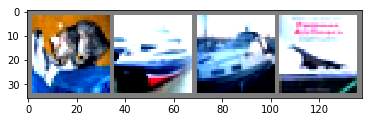

GroundTruth:    cat  ship  ship plane


In [11]:
image_batch, label_batch = next(iter(val_dataloader))
image_batch, label_batch = image_batch.to(device), label_batch.to(device)

# print images
imshow(torchvision.utils.make_grid(image_batch))
print('GroundTruth: ', ' '.join('%5s' % classes[label_batch[j]] for j in range(batch_size)))

Okay, now let us see what the neural network thinks these examples above are:



In [12]:
outputs = model(image_batch)

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [13]:
predicted = torch.argmax(outputs, dim=1)

print("Predicted: {}".format(" ".join(classes[predicted[j]]for j in range(batch_size))))

Predicted: cat ship plane plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [14]:
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for batch in tqdm(val_dataloader):
        image_batch, label_batch = batch
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        
        outputs = model(image_batch)
        predicted = torch.argmax(outputs, dim=1)
        
        total += labels.size(0)
        correct += (predicted == label_batch).sum().item()

print("Accuracy of the network on the 10000 val images: {:.4}%".format(100 * correct / total))


Accuracy of the network on the 10000 val images: 59.23%


That looks waaay better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something. You're awesome.

## Task 2 (2 points). Finetune pretrained model

As we already know, **deep learning** is about hierarchical feature learning. It means that major part of neural network just learns how to extract features, and only last layers laearn how to solve target task (e.g. classification). So if we take some modern model carefully trained on a big dataset, it's likely that it has learnt to extract some useful features from data.

In this part of the seminar, we'll finetune [AlexNet](https://arxiv.org/abs/1404.5997) (one of the first deep CNN-architectures) trained on ImageNet (1000-class image dataset).

We'll do following steps:
1. Load and initialize the pretrained model
2. Freeze part of the network responsible for extracting *features*
3. Replace existing *classifying* part of the network with yours
4. Finetune resulting model

As you can read in the [AlexNet paper](https://arxiv.org/abs/1404.5997), takes images of size 224x224. Add proper resize to our transforms:

In [15]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Setup dataloaders (the same as before, but with different transform):

In [16]:
train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

print("len(train_dataset) =", len(train_dataset))

val_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)
val_dataloader= torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print("len(val_dataset) =", len(val_dataset))

Files already downloaded and verified
len(train_dataset) = 50000
Files already downloaded and verified
len(val_dataset) = 10000


### 1. Load and initialize the pretrained model

Now let's load already pretrained AlexNet model. Luckily `torchvision` gives us easy interface to load popular pretrained models (weights downloading can take some time): 

In [17]:
model = torchvision.models.alexnet(pretrained=True).to(device)

Look at [source code](https://github.com/pytorch/vision/blob/master/torchvision/models/alexnet.py) for AlexNet for deeper understanding of how model works. Let's print it:

In [18]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

As we can see, AlexNet has 2 main submodules:
 - **features**: extracts high-abstract features from input images
 - **classifier**: classifies resulting features in 1000 ImageNet classes
 
`features` module is very useful for us, and we'll use it as it is. `classifier` module is more specific for ImageNet classes and we'll replace it with our own.

We don't want to finetune `features` module, so let's freeze it by setting `requiers_grad=False` to its parameters:

In [30]:
for layer in model.features.parameters(): ## iterate over parameters and freeze them
    layer.requiers_grad = False

Now let's build our own classifier. Use [nn.Sequential](https://pytorch.org/docs/stable/nn.html#torch.nn.Sequential) for simplisity. Also try using [nn.Dropout](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout) just as in original model:

In [31]:
classifier = nn.Sequential(
    nn.Dropout(inplace=True),
    nn.Linear(9216, 10),
) ## your code here

Replace existing classifier with ours:

In [32]:
model.classifier = classifier

Setup criterion and optimizer.

**Note**: we pass to optimizer only those parameters that we want to optimize.

In [33]:
criterion = nn.CrossEntropyLoss().to(device)
opt = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)

Run training for only 1 epoch:

In [34]:
for epoch in tqdm(range(1)):  # loop over the dataset multiple times
    running_loss = 0.0
    for batch in tqdm(train_dataloader):
        # get the inputs
        image_batch, label_batch = batch
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        
        # zero the parameter gradients
        opt.zero_grad()

        # forward + backward + optimize
        outputs = model.forward(image_batch) ## your code here
        loss = criterion(outputs, label_batch) ## your code here
        
        loss.backward()
        opt.step()
        
        running_loss += loss.item()
        
        
    print("[epoch {}] loss: {:.3}".format(epoch, running_loss / len(train_dataloader)))

[epoch 0] loss: 6.23


Validate:

In [35]:
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for batch in tqdm(val_dataloader):
        image_batch, label_batch = batch
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        
        outputs = model(image_batch)
        predicted = torch.argmax(outputs, dim=1)
        
        total += labels.size(0)
        correct += (predicted == label_batch).sum().item()

print("Accuracy of the network on the 10000 val images: {:.4}%".format(100 * correct / total))

Accuracy of the network on the 10000 val images: 77.06%
